In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Input, Conv2D, Conv2DTranspose, Dropout, LeakyReLU, ReLU, ZeroPadding2D, GroupNormalization, Concatenate
from keras.models import Model
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam 
import keras
from keras import Sequential
from keras import layers

## Loading the Data for use

In [160]:
monet_dir = tf.io.gfile.glob("gan-getting-started/monet_tfrec/*.tfrec")
photo_dir = tf.io.gfile.glob("gan-getting-started/photo_tfrec/*.tfrec")

In [161]:
img_size = [256, 256]

def decode_img(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32)/255)*2 - 1
    image = tf.reshape(image, shape= [*img_size, 3])
    return image

def read_tfrec(example):
    tfrec_format = {
        'image_name' : tf.io.FixedLenFeature([], tf.string),
        'image' : tf.io.FixedLenFeature([], tf.string),
        'target' : tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    image = decode_img(example['image'])
    return image

#### These sections go throught the photo files and generate images for use. 

In [162]:
def load_data(files):
    data = tf.data.TFRecordDataset(files)
    data = data.map(read_tfrec)
    return data

In [163]:
monet_data = load_data(monet_dir).batch(1)
photo_data = load_data(photo_dir).batch(1)

In [164]:
monet_data

<_BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>

### Exploring the Data(EDA)

In [165]:
monet_ex = next(iter(monet_data))
photo_ex = next(iter(photo_data))

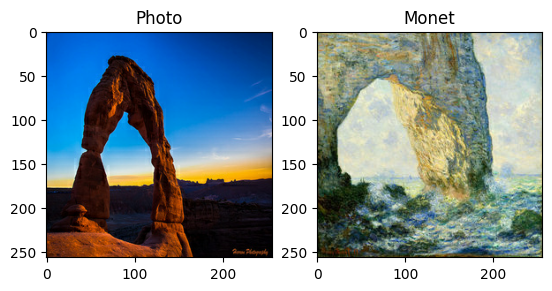

In [166]:
plt.subplot(1,2,1)
plt.title('Photo')
plt.imshow(photo_ex[0]* 0.5 + 0.5)

plt.subplot(1,2,2)
plt.title('Monet')
plt.imshow(monet_ex[0]*0.5 + 0.5)

#### Below is the starting to building the GAN cycle

In [167]:
def downsample(filters, size, instance_norm=True):
    initializer = tf.random_normal_initializer(0,0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0, stddev=0.02)
    
    model = Sequential()
    model.add(Conv2D(filters, size, strides=2, padding='same', kernel_initializer= initializer, use_bias=False))

    if instance_norm:
        model.add(GroupNormalization(groups=-1, gamma_initializer=gamma_init))
    
    model.add(LeakyReLU())

    return model

In [168]:
def upsample(filters, size, dropout=False):
    initializer = tf.random_normal_initializer(0, 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0, stddev=0.02)

    model = Sequential()
    model.add(Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    model.add(GroupNormalization(groups=-1, gamma_initializer=gamma_init))

    if dropout:
        model.add(Dropout(0.5))
    
    model.add(ReLU())

    return model

#### Above are the sections that manipulate photos siziing

#### Below is the actual generator that create outputs for the model to analyse

In [169]:
def Generator():

    down_stack = [
        downsample(64, 4, False), 
        downsample(128, 4), 
        downsample(256, 4), 
        downsample(512, 4), 
        downsample(512, 4), 
        downsample(512, 4), 
        downsample(512, 4), 
        downsample(512, 4), 
    ]

    up_stack = [
        upsample(512, 4, True),
        upsample(512, 4, True), 
        upsample(512, 4, True), 
        upsample(512, 4), 
        upsample(256, 4),
        upsample(128, 4), 
        upsample(64, 4), 
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(
        3, 
        4,
        strides=2,
        padding='same',
        kernel_initializer=initializer,
        activation='tanh') 
    
    i = Input( shape= [256, 256, 3])
    x = i


    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])


    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)
    model = Model(i, x)

    return model

##### The model below is the actual processor for the generated photos to be disected for checking the photos

In [170]:
def Discriminator():
    i = Input(shape= [256, 256, 3])
    x= downsample(64, 4) (i)
    x= downsample(128, 4) (x)
    x= downsample(256, 4) (x)
    
    x= ZeroPadding2D() (x)

    initializer= tf.random_normal_initializer(0,0.02)
    gamma_init=keras.initializers.RandomNormal(mean=0, stddev=0.02)

    x= Conv2D(512, 4, strides=1, padding='same', kernel_initializer=initializer, use_bias=False) (x)
    x= GroupNormalization(groups=-1, gamma_initializer=gamma_init) (x)
    x= LeakyReLU () (x)

    x= ZeroPadding2D() (x)

    x= Conv2D(1, 4, strides=1, padding='same', kernel_initializer=initializer) (x)

    model= Model(i, x)

    return model

In [171]:
monet_generator = Generator()
monet_discriminator = Discriminator()
photo_generator = Generator()
photo_discriminator = Discriminator()

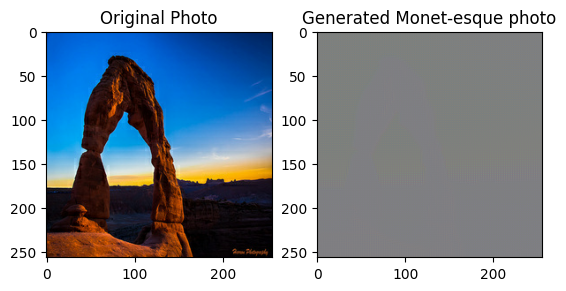

In [172]:
photo_to_monet = monet_generator(photo_ex)

plt.subplot(1,2,1)
plt.title('Original Photo')
plt.imshow(photo_ex[0]*0.5 + 0.5)

plt.subplot(1,2,2)
plt.title('Generated Monet-esque photo')
plt.imshow(photo_to_monet[0]*0.5 + 0.5)

#### Here we have the actual GAN function that will take in all the previous models and apply to photos

In [173]:
class CycleGAN(keras.Model):

    def __init__(
            self,
            monet_gen,
            monet_disc,
            photo_gen,
            photo_disc,
            lambda_cycle= 10
    ):
        super(CycleGAN, self).__init__()
        self.m_gen=monet_gen
        self.m_disc=monet_disc
        self.p_gen=photo_gen
        self.p_disc=photo_disc
        self.lambda_cycle=lambda_cycle

    def compile(
            self,
            m_gen_optimizer,
            m_disc_optimizer,
            p_gen_optimizer,
            p_disc_optimizer,
            gen_loss_function,
            disc_loss_function,
            cycle_loss_function,
            identity_loss_function
    ):
        super(CycleGAN, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_function = gen_loss_function
        self.disc_loss_function = disc_loss_function
        self.cycle_loss_function = cycle_loss_function
        self.identity_loss_function = identity_loss_function

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            same_photo = self.p_gen(real_photo, training=True)
            same_monet = self.m_gen(real_monet, training=True)

            disc_real_photo = self.p_disc(real_photo, training=True)
            disc_real_monet = self.m_disc(real_monet, training=True)

            disc_fake_photo = self.p_disc(fake_photo, training=True)
            disc_fake_monet = self.m_disc(fake_monet, training=True)

            gen_monet_loss = self.gen_loss_function(disc_fake_monet)
            gen_photo_loss = self.gen_loss_function(disc_fake_photo)

            total_cycle_loss = (self.cycle_loss_function(real_monet, cycled_monet, self.lambda_cycle) + 
                                self.cycle_loss_function(real_photo, cycled_photo, self.lambda_cycle))
            
            total_gen_monet_loss = (gen_monet_loss + total_cycle_loss + 
                                    self.identity_loss_function(real_monet, same_monet, self.lambda_cycle))
            
            total_gen_photo_loss= (gen_photo_loss + total_cycle_loss + 
                                   self.identity_loss_function(real_photo, same_photo, self.lambda_cycle))
            
            disc_monet_loss = self.disc_loss_function(disc_real_monet, disc_fake_monet)

            disc_photo_loss = self.disc_loss_function(disc_real_photo, disc_fake_photo)


        gen_monet_gradients= tape.gradient(total_gen_monet_loss, self.m_gen.trainable_variables)          
        gen_photo_gradients= tape.gradient(total_gen_photo_loss, self.p_gen.trainable_variables)           
        
        disc_monet_gradients= tape.gradient(disc_monet_loss, self.m_disc.trainable_variables)               
        disc_photo_gradients= tape.gradient(disc_photo_loss, self.p_disc.trainable_variables)
        
        self.m_gen_optimizer.apply_gradients(zip(gen_monet_gradients, self.m_gen.trainable_variables))      
        self.p_gen_optimizer.apply_gradients(zip(gen_photo_gradients, self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(disc_monet_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(disc_photo_gradients, self.p_disc.trainable_variables))

        return {
            'gen_monet_loss' : total_gen_monet_loss,
            'gen_photo_loss' : total_gen_photo_loss,
            'disc_monet_loss' : disc_monet_loss,
            'disc_photo_loss' : disc_photo_loss
        }
        

#### Below we will make the loss functions for the model outputs

In [174]:
def gen_loss_fn(generated):

    return BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [175]:
def disc_loss_fn(real, generated):
    loss_real = BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
    loss_fake = BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

    total_loss = (loss_real + loss_fake)/2

    return total_loss

In [176]:
def cycle_loss_fn(real, cycled, lambda_cycle):
    loss = tf.reduce_mean(tf.abs(real - cycled))

    return lambda_cycle * loss

In [177]:
def identity_loss_fn(real, same, Lambda):
    loss = tf.reduce_mean(tf.abs(real - same))

    return Lambda * loss * 0.5


#### The final part of the testing is adding the values to the model to run the whole program

In [178]:
m_gen_opt = Adam(learning_rate=2e-4, beta_1=0.5)
m_disc_opt = Adam(learning_rate=2e-4, beta_1=0.5)

p_gen_opt = Adam(learning_rate=2e-4, beta_1=0.5)
p_disc_opt = Adam(learning_rate=2e-4, beta_1=0.5)

In [179]:
cyclegan_model= CycleGAN(monet_generator, monet_discriminator, photo_generator, photo_discriminator, 10)
cyclegan_model.compile(m_gen_opt, m_disc_opt, p_gen_opt, p_disc_opt, gen_loss_fn, disc_loss_fn, 
                        cycle_loss_fn, identity_loss_fn)

In [180]:
cyclegan_model.fit(tf.data.Dataset.zip((monet_data, photo_data)), epochs= 50)

Epoch 1/50
300/300 [==============================] - 896s 3s/step - gen_monet_loss: 5.1092 - gen_photo_loss: 5.1696 - disc_monet_loss: 0.6275 - disc_photo_loss: 0.6520
Epoch 2/50
300/300 [==============================] - 1183s 4s/step - gen_monet_loss: 3.6248 - gen_photo_loss: 3.5925 - disc_monet_loss: 0.6458 - disc_photo_loss: 0.6821
Epoch 3/50
300/300 [==============================] - 7577s 25s/step - gen_monet_loss: 3.5657 - gen_photo_loss: 3.5081 - disc_monet_loss: 0.6384 - disc_photo_loss: 0.6605
Epoch 4/50
300/300 [==============================] - 5977s 20s/step - gen_monet_loss: 3.5435 - gen_photo_loss: 3.4913 - disc_monet_loss: 0.6119 - disc_photo_loss: 0.6269
Epoch 5/50
300/300 [==============================] - 6221s 21s/step - gen_monet_loss: 3.4492 - gen_photo_loss: 3.3742 - disc_monet_loss: 0.6101 - disc_photo_loss: 0.6291
Epoch 6/50
300/300 [==============================] - 3888s 13s/step - gen_monet_loss: 3.3002 - gen_photo_loss: 3.3456 - disc_monet_loss: 0.6305 - d

#### Lastly is checking the output via photos, and saving/sending output

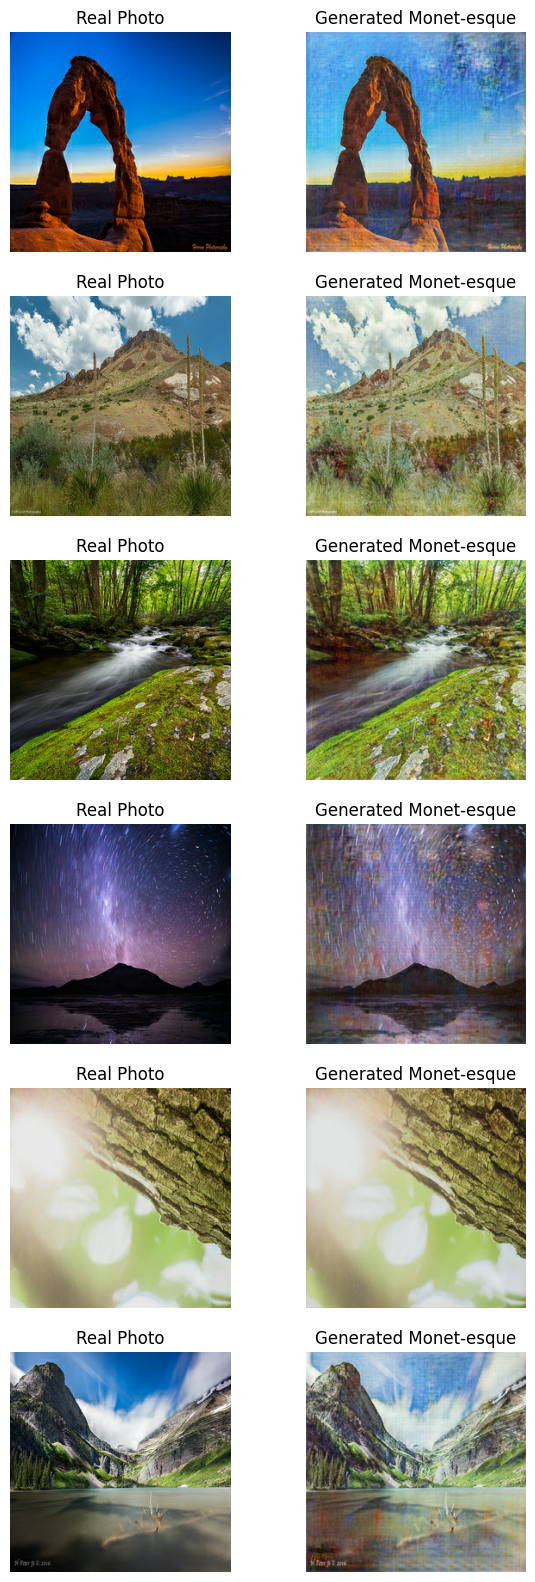

In [181]:
fig,ax= plt.subplots(6,2, figsize=(7,20))
for i,img in enumerate(photo_data.take(6)):
    pred= monet_generator(img, training= False)[0].numpy()   # training= False to make sure not to update model's weights
    pred= (pred*127.5 + 127.5).astype(np.uint8)              # making pixel range to [0,255]
    img= (img[0]*127.5 + 127.5).numpy().astype(np.uint8)
    
    ax[i,0].imshow(img)
    ax[i,1].imshow(pred)
    ax[i,0].set_title('Real Photo')
    ax[i,1].set_title('Generated Monet-esque')
    ax[i,0].axis('off')
    ax[i,1].axis('off')

In [182]:
import PIL
# ! mkdir ../images

In [183]:
i = 1
for img in photo_data:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("images/" + str(i) + ".jpg")
    i += 1

###### References: 
###### https://www.kaggle.com/code/conradkleykamp/using-gans-to-create-monet-style-art-cyclegan 
###### https://www.kaggle.com/code/faptimus420/monet-cyclegan-generator-wip
###### https://www.kaggle.com/code/hidetaketakahashi/monet-styletransfer